In [12]:
%matplotlib inline
import numpy as np
from numpy import linalg as la
#ディガンマ関数のライブラリ
from scipy.special import digamma
#ディリクレ分布のライブラリ
from scipy.stats import dirichlet
from scipy import stats
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt

In [13]:
def dataset(mu,sigma,pi):
    for i in range(k):
        samplesB = np.random.multivariate_normal(mu[i],sigma[i],int(N*pi[i])).T
        if(i>=1):
            samplesA = np.column_stack((samplesA,samplesB))
        else:
            samplesA = samplesB
    sample = np.c_[samplesA[0],samplesA[1]]
    
    plt.scatter(sample[:,0],sample[:,1],color='g',marker='+',alpha=0.8)
    return sample

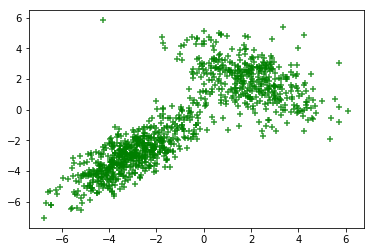

In [14]:
#初期設定
N = 1000 #データ数
mu = [[-3,-3],[2,2]]
sigma = [[[1.9,1.5],[1.5,1.9]],
        [[2.1,-1.0],[-1.0,2.1]]]
pi=[0.6,0.4]
k=2 #データ群の個数
K=3 #分布の個数
D=2 #次元
#samples = dataset(mu,sigma,pi)
#print(type(samples))
samples = np.array([[-3.9101205085572235,-3.4302624783422564],
[-5.346696393400929,-5.601881968482122],
[-3.8957214784850613,-3.2817512825664164],
[-1.1482009560113118,-1.3315427289296493],
[-3.204020369974698,-3.2444395468398013],
[-3.1967292526551745,-4.6061395977286095],
[-4.2405631794704295,-2.42685726953653],
[-3.4947550453941068,-3.8291582986546016],
[-3.276975077121082,-2.8200468653693456],
[-4.105044936892618,-3.7876656029677322],
[-2.918173207145111,-1.7566504231258118],
[-3.986149277786406,-4.703234781862665],
[-1.4044051408105835,-3.7536947006591346],
[-0.9158487060760159,-1.0069316321132376],
[-0.7824141656908927,-1.8785910989045305],
[-4.75879887145358,-4.282336185226621],
[-3.546375582275858,-2.5475315861177092],
[-3.462831532391589,-2.853014507741508],
[-4.77026951326287,-2.8309655095726134],
[-0.62204499141578,-1.4013402951007938],
[-3.996198380502014,-3.8095632028995094],
[-2.0071592113067487,-2.457344141789026],
[-4.2158207584149,-2.6381631622067063],
[-3.0356311556240936,-3.123939092073954],
[-4.546272385140976,-3.4576553714086393],
[-1.3657439323608078,-1.9712756964251157],
[-3.0005704987581687,-1.9985179748284647],
[-2.2635512597344434,-3.1076197173982183],
[-2.472768835404209,-3.1310553894895574],
[-2.0822737356062024,-2.4857775440682306],
[-3.6110577613382517,-1.682582818515072],
[-3.282743595142297,-3.7741798607286556],
[-4.049833655845594,-5.124257498977057],
[-3.938980085494633,-3.626169258261349],
[-3.294416558484937,-3.4313668531565065],
[-0.33691745990473754,-0.980452323344446],
[-1.8241515471321879,-1.8583957083784064],
[-3.2886201166960403,-1.5878622398145545],
[-3.480342930360229,-3.3908266163851914],
[-2.5707658983025077,-3.033217395336414],
[-5.466280104939527,-3.4676135750235515],
[-2.8458991155663953,-2.649948057152479],
[-2.4882718943420477,-3.991577539728091],
[-4.513023014605022,-5.436667473139087],
[-3.2999400274032937,-2.5456800550171637],
[-4.168196473198165,-3.833608905232568],
[-3.972273158658605,-4.549220731907452],
[-3.0719296646785104,-3.2597075029292495],
[-6.596622459527232,-5.343482574544256],
[-1.8582337918449294,-2.7392753676731147],
[-4.6959264554983555,-3.9244937956182238],
[-1.289785207358239,-2.741489206114202],
[-1.6374353382823768,-3.7367196645587706],
[-4.284166943806607,-4.174797683669953],
[-1.8999806908319887,-1.9815275245652135],
[-2.8105800168314006,-2.3730756884082727],
[-2.6910613403545045,-2.298090114410953],
[-5.0246158639687835,-4.125383211887284],
[-4.909110449705164,-2.87304154006509],
[-2.505571595078237,-2.348172823805509],
[-3.87285298863099,-2.562156280233337],
[-2.7213179121499684,-3.0829614155191276],
[-5.162324713704782,-6.1135597986488275],
[-2.542053637332174,-1.8943468096589247],
[-4.62743269608553,-4.0075595163398265],
[-4.727562269420337,-3.1925276980485977],
[-2.0136206532649443,-1.1773552367025961],
[-0.28887713923623304,-0.32284770533740836],
[-5.0753007443126545,-5.576260282864328],
[-4.0726748243612985,-4.298249324877624],
[-4.002232613994032,-4.954721571583549],
[-3.9977878141636007,-4.005385818244512],
[-1.6981593692736197,-2.494858438444822],
[-4.393692047517137,-3.8691625486452343],
[-3.4899376686011623,-4.2070258121074495],
[-2.7553570841317843,-1.2757000104580725],
[-2.8755970406787714,-1.8378684202689581],
[-3.3879839244386405,-5.068603903391576],
[-4.441117648586014,-5.34197346667661],
[-4.698155777433914,-4.5748560452446005],
[-3.5908008317802396,-3.26715955220349],
[-2.6898359833184498,-2.8083772245439587],
[-5.239023467437653,-3.542575879271177],
[-2.8532450827471183,-1.8633751422828597],
[-2.238229635406554,-2.6451824651692624],
[-1.770852348302016,-2.2096581285825145],
[-2.4939098821984107,-2.95382231819786],
[-2.222751519412704,-1.8420094686341357],
[-3.9576401546563376,-5.209262292579425],
[-4.1690227992727475,-2.333764341289228],
[-2.7212542411511933,-3.6190928295505],
[-6.499501429913294,-5.334810005424727],
[-2.4144364620078482,-2.275926987133779],
[-3.048074029984262,-2.7729697745544977],
[-0.9299317768893589,-0.9892463701523062],
[-5.080821498091097,-4.249573036529],
[-6.469973208724266,-6.209753995369651],
[-1.7796373026943535,-1.3149724713779865],
[-5.72966823068646,-4.529213049960914],
[-4.514166073744609,-4.002683496292689],
[-1.0570710144259765,-0.6366124098525008],
[-3.999092287406509,-3.731097173842888],
[-3.0724474124552,-2.977206637849349],
[-4.41376789734151,-4.4459865277288255],
[-3.6242396023622874,-4.527253488233963],
[-0.5453171805729751,-0.13504917213086953],
[-1.035265567013558,-2.3534390230311453],
[-3.2318930067740537,-2.228272748140276],
[-4.883285738530294,-4.314867433483602],
[-1.2260573500288612,-1.399986051242237],
[-1.131252138359645,-1.0705252508956316],
[-2.940195377604157,-3.0116054027316297],
[-4.007343626848684,-2.1651540037306014],
[-2.8630744515161237,-2.6566624568172545],
[-1.862225156592553,-2.358973769517286],
[-2.7765868271122516,-2.0354937603240915],
[-2.709072285363384,-1.9750167981716442],
[-2.7716356850024346,-2.247983409524921],
[-4.417906919024603,-4.968598225401289],
[-1.6305679686370762,-2.8549305020676417],
[-4.468998602633179,-3.4116670225043864],
[-0.8607761259800317,-1.2833487528474703],
[-2.1460871039990956,-2.637357951877024],
[-5.437894294203428,-5.521539830461429],
[-1.519374882760509,-1.470150048252091],
[-3.817686180111146,-4.413265124448939],
[-3.380928078660754,-2.3386422959154802],
[-5.322864287424027,-4.234587695189747],
[-3.2698245859094275,-3.4496816572567193],
[-2.903681396886812,-2.6290863631258254],
[-4.351880426774615,-3.5245779414363154],
[-4.817974677820649,-4.894520080853673],
[-2.731318906371797,-3.140007381649125],
[-1.230839360955516,-0.9227251390707529],
[-2.500757148201529,-3.2258977239646303],
[-4.203131539637177,-3.6385689144956928],
[-4.491169817482081,-4.745480584053429],
[-3.530139684626622,-2.3906555988152416],
[-6.736965175298341,-7.051079979945304],
[-1.5396219621989924,-1.7914031250437283],
[-1.1988240668836485,-3.1029359361926554],
[-0.6792668580807191,-1.8220558074643436],
[-3.4671002971975473,-3.555576332576346],
[-3.27461448190912,-2.916381052896217],
[-2.9693425506857105,-3.528991890256057],
[-3.0375614625252467,-3.0348535217657964],
[-1.6981276836781287,-1.8260962331186834],
[-4.202041297562743,-4.859543175886732],
[-3.82953366063097,-4.347603138823961],
[-3.146682037662493,-4.138572051610549],
[-1.8565020841611264,-0.4464599626596306],
[-1.7552399877064508,-2.0659534691714314],
[-3.8381811361716873,-4.074405639230296],
[-2.102805507253218,-2.4476050512017142],
[0.08931798435627991,0.41586519072820716],
[-2.0957470735193615,-2.918883035229185],
[-3.946764404464397,-3.4442270294387543],
[-0.4290280933082036,0.6450067114865461],
[-3.615344383206895,-1.5753720747755986],
[-0.8183201018558717,-1.7733705701679057],
[-3.846565406626347,-2.412423575041343],
[-3.6681711953975,-3.8405786847473093],
[-4.751762286438476,-2.9907760797018934],
[-1.3088891149259951,-2.7267880574646868],
[-2.5986040934563266,-3.1141604206825524],
[-0.926478588781777,-0.05404569409459192],
[-1.5379132546317658,-1.1594154123475402],
[-2.099128048392328,-1.0915432694306921],
[-3.8905251509174694,-3.2860348217840296],
[-3.959719383987966,-3.3132926765062853],
[-1.9687256539668647,-2.0806498841924],
[-3.66751290196198,-2.1615529967168445],
[-3.234537841815225,-2.449659578703524],
[-3.5172766044804566,-3.5218293092224116],
[-3.9595794179104957,-3.855302105983009],
[-1.02856959049803,-0.3542285997821115],
[-2.532463227782353,-1.7522548173036554],
[-3.8431005250738983,-3.801851871167748],
[-2.2866866977884786,-2.7832707189420076],
[-1.2304240868436156,-1.6129552405698566],
[-2.3295600930929172,-3.5894979715621105],
[-2.1503174161413137,-3.142811014169199],
[-4.110006290574006,-2.5152127609091806],
[-2.147681926474306,-2.616943659850889],
[-0.7020163145750766,-2.528975970662561],
[-2.1420899206221367,-2.363841568687441],
[-3.807344185405271,-2.3749570976536165],
[-0.3446830813832502,-0.9997705623870501],
[-2.8940438395422143,-4.879777702144071],
[-6.185223292696733,-5.531682392704684],
[-2.0792820280955553,-2.9499614381016337],
[-2.4339480068298336,-3.800212248539098],
[-3.380263669423221,-2.610665280591484],
[-3.3455382691043063,-2.4765961366720797],
[-2.825169556743706,-3.1497156756233813],
[-3.5356225479371837,-5.194462855570226],
[-0.30220528063807617,-1.894448241275597],
[0.4323788873744254,-0.7762557778725063],
[-2.944046308973434,-2.101191784611419],
[-2.7460115236820357,-3.4549501100727693],
[-3.390325650510068,-3.7490429940988497],
[-4.866098107222792,-4.289288618114053],
[-2.503198598747759,-2.1628612710915944],
[-3.4305170941381693,-3.2981713185197963],
[-1.5767415816437442,-2.822519987234198],
[-3.5689276979214966,-4.204528091669607],
[-2.936432293201848,-1.490835239056798],
[-3.440110901315748,-3.076486924706531],
[-0.909753506530401,-1.1192753609306483],
[-3.1622084317816603,-2.3309786813815903],
[-3.0617435050116897,-2.871831521973745],
[-3.6231401763310047,-3.493969827085812],
[-2.5680339586061267,-2.533883766946455],
[-2.847773214217715,-2.8063527050034534],
[-3.8498933102851267,-4.689873648996001],
[-3.8890887242263394,-3.7246161989968747],
[-2.284568359884475,-3.6662906349507094],
[-1.4171101664761532,-0.53919872804512],
[-3.7554441782473322,-2.818224261724318],
[-3.760578670713591,-3.4619263772632523],
[-2.6825127170277296,-1.8498458041617978],
[-4.319293231253182,-4.862735380742686],
[-3.4629448841134214,-3.668512956687281],
[-5.375976704821049,-6.437030047865928],
[-5.200797073165777,-4.4799641527213865],
[-2.3052947597410243,-1.9699570070856633],
[-4.560361733780477,-4.234343062588796],
[-1.1524591219641172,-0.5445359008354966],
[-2.8044012981672974,-2.9193917728116237],
[-2.998178363928291,-3.1878459850147953],
[-3.889845161856316,-4.43775527272059],
[-1.5648834106678866,-3.2268886696605046],
[-6.6707679651182135,-6.088668923105677],
[-0.4110127677565818,-1.5969089335176387],
[-4.676170436198332,-4.342534907818766],
[-3.5553505534736374,-2.896720884391481],
[-5.322825800575528,-5.33987600366954],
[-2.747364315397422,-2.1899818883536852],
[-4.208607101106779,-4.110138800985869],
[-2.277427702565695,-1.1681407172632423],
[-2.5104252614070175,-1.727420031778014],
[-2.358278823564398,-2.1650477290432013],
[-3.3469072540120988,-3.279231475575719],
[-1.3609268726247723,-1.148619968750554],
[-4.861956523020994,-4.17234697150983],
[-1.8421010408628369,-2.6513885546813745],
[-3.009400292916844,-2.9472732873112504],
[-4.2987649948027205,-3.7392066034139497],
[-3.0535809167081744,-2.9023707931456357],
[-1.9504171764185176,-1.8590562135506477],
[-0.6660686715325035,-0.4284449205217702],
[-2.5151024754367723,-1.126552323160043],
[-4.480154311593203,-4.4189744366495365],
[-3.308459524374348,-4.6664378458585425],
[-3.273303422016916,-2.2512006969585],
[-4.561883241552856,-4.172676212722569],
[-3.017246236932821,-2.8494874677173265],
[0.14292487705825918,-1.331350345632532],
[-1.0174522706946925,-0.5683062751743755],
[-2.7249319321252807,-2.9167334321670157],
[-2.1060123170193084,-1.604774969515356],
[-3.5570372892462494,-2.6330817157272297],
[-2.6180911655021735,-2.3511425908484704],
[-1.6783533973671196,-2.4511928647772274],
[-3.8835296243429047,-2.1975689543649377],
[-5.531177747591932,-3.1519133834150876],
[-2.094268682981588,-4.072993892631375],
[-1.5356690016168504,-1.0441185995981643],
[-3.86097053682986,-3.3226416492154462],
[-2.0886296028891644,-1.8404232330388355],
[-4.321381421460039,-4.38466493763646],
[-3.467486819510613,-4.864014661868067],
[-3.8795033004931914,-3.157385202539477],
[-2.8242012705926123,-2.2512564334896146],
[-2.4661315722284476,-3.0800217823569933],
[-3.7484972647435506,-1.115855053861248],
[-3.1460219394975235,-3.1683734739387637],
[-0.2986944534546341,0.4411425006017633],
[-1.675099618951242,-3.008037273016024],
[-3.701129820098568,-4.619840336848124],
[-2.8647160736633976,-3.0265927793295115],
[-4.226354107644541,-4.912866497533114],
[-2.923024386446727,-1.8555446504993807],
[-4.326606151557601,-4.412044472870507],
[-3.95035515101224,-2.262392994072229],
[-1.3124287235828918,-1.863250470313531],
[-1.4843122759457095,-2.0701319444431934],
[-3.3621696000528547,-2.5640690637671115],
[-2.593461439402429,-3.469222959321123],
[-3.5705532069647883,-2.950175569022655],
[-4.086645512533135,-4.50441522247129],
[-2.4861897022467057,-1.5314207161204412],
[-1.7137513315111073,-0.5219213508229292],
[-2.8775656480588263,-2.050569608980463],
[-2.7282633852825926,-3.280000217500606],
[-2.250983420196736,-2.7838271697822297],
[-3.2527904764402056,-2.9573181111479663],
[-3.82939094094419,-3.602256929392072],
[-3.0721211213992867,-3.102146222643747],
[-3.702565451624496,-3.4944792986288795],
[-4.363585799140992,-4.012714638033299],
[-2.620785592617902,-2.1247244808584638],
[-0.1564318050760014,-0.12373941160977653],
[-2.1422532584146468,-2.933445720458353],
[-2.4950941991882103,-3.4330571358894417],
[-2.119594848605179,-3.7069096789171585],
[-5.094695017863245,-4.216568677676396],
[-3.857743617247377,-2.109802350199535],
[0.36556642297191466,-0.5113326716585753],
[-2.8079531656800674,-2.285559712237278],
[-2.039950239171217,-1.4720038631001549],
[-2.4867200908171423,-2.5081430530665654],
[-5.473253701348813,-5.401298683348613],
[-4.019456195456023,-3.81638429755569],
[-4.414783565105303,-3.697967243066426],
[-3.740946369407528,-2.8584485804661686],
[-0.31848295269925586,-1.6128533060174468],
[-2.445486621260698,-3.050335048335409],
[-3.5503588598018414,-3.0281207799493015],
[-0.4569116859932749,0.4124087245418817],
[-3.4398702884278984,-3.5262010251958347],
[-2.510936404592002,-1.5314318275540757],
[-2.179792163029129,-2.6669384090633894],
[-2.958078369114676,-2.8914822769429014],
[0.047716956825848644,0.23218181227372003],
[-3.0822919849857713,-2.464799380564889],
[-1.5897331428766146,-3.2870880135262714],
[-4.6921801747470475,-4.704417859412437],
[-3.9042584390793236,-3.425121227388724],
[-3.896342598299987,-4.9065055193391744],
[-4.6213389367968105,-4.2227382461532805],
[-4.526332494954267,-4.20413636639796],
[-2.560870733793118,-2.6089857395174185],
[-3.8891100824239393,-5.346412526385606],
[-5.604407060645317,-6.487390476914519],
[-2.93569011998282,-3.361957843230328],
[-2.2624441621087685,-3.6938388549413266],
[-3.432596613056066,-3.6690038516885286],
[-2.5987259775831952,-2.105412024241539],
[-5.518342236344083,-4.326148935045403],
[-2.490036065344367,-2.9527856526788496],
[-1.8353033140864259,-2.7535292117983303],
[-2.9723666356299416,-1.3080123584582197],
[-1.7400557461745827,-2.0171071958902376],
[-3.3945893944367245,-4.309481639078159],
[-4.804308940491763,-5.9004579049146315],
[-2.4072350914598712,-1.7424679571558916],
[-1.7610941925857757,-2.5065742210795436],
[-2.7675243041672815,-1.8850426391103496],
[-4.807823009632436,-4.992066602925514],
[-4.533839143591571,-2.7592960581645882],
[-4.393710012157147,-3.605474662077693],
[-2.7127511696175874,-4.413133578531127],
[-1.89311709884568,-1.432934736761891],
[-3.0998406742615,-4.369414544157052],
[-3.785919121034614,-5.515124560969028],
[-4.050214100446268,-3.945251909410427],
[-4.323827236361985,-4.650120422321612],
[-3.564351081009641,-2.669624724968391],
[-1.6255253073668479,-2.6520052390882696],
[-2.323434656334378,-0.7610046236853432],
[-3.405943759598978,-2.7556215713283594],
[-2.5835894131860297,-2.681508575116313],
[-3.038212727469157,-4.2022933680120165],
[-4.792806912178835,-4.042569025654676],
[-2.2303574094640126,-1.1663928038469185],
[-3.8815436543642106,-4.149096107797752],
[-3.143633895022104,-2.5036378028537127],
[-3.372513770698626,-3.9315059463347364],
[-2.039622822683949,-2.003297066537612],
[-4.071003325041576,-5.005659464205003],
[-2.156042920177539,-2.6629717945587106],
[-5.1723406546747155,-5.784717951767652],
[-3.3445038069542727,-2.072966391018067],
[-2.5246181499043616,-2.2088102619598997],
[-2.1777293752140197,-2.7440172980898483],
[-5.055151160151084,-5.013068823239635],
[-2.8954987690817107,-2.8055279945618308],
[-2.58367243279248,-1.2726915710738713],
[-2.6281682139649805,-3.685470601503408],
[-3.4988517606967946,-3.5907384250752923],
[-2.8516882587934385,-3.5968143539124755],
[-4.239416896014175,-4.524258544956327],
[-2.8687579988614016,-3.700146006495742],
[-2.2084275369481223,-2.655710542365956],
[-3.6825827082583906,-1.7579875407019672],
[-5.249187209832057,-3.054113582442043],
[-1.7818469215669375,-2.3842075092831454],
[-5.189650714887941,-6.553790793102708],
[-6.083473173035066,-5.048656514390977],
[-0.5397704603884708,-1.8870111909626741],
[-4.358357809997719,-3.9746132945914],
[-4.867988732807797,-3.944718989691849],
[-2.1166218850283247,-2.5982307322051845],
[-3.8111888529520894,-3.4540935187557706],
[-1.7323963148464347,-2.1000202570563853],
[-3.8938049690112466,-3.5374392999293662],
[-2.783020281333104,-2.0062868511276744],
[-4.266942777465345,-2.915189199890513],
[-3.491534079087946,-2.1700455261746985],
[-3.4789808948304835,-1.6892132300532245],
[-1.7134706978994876,0.12007598035870526],
[-1.2571422732354787,-2.242730590333233],
[-2.842412962236354,-3.3218262994612253],
[-0.5875489305335777,-0.687998151889631],
[-0.23960086003006742,0.28802891902477956],
[-2.604003722636047,-3.089480599051735],
[-3.8902910898965937,-2.344083045813118],
[-5.0452690850208715,-3.4893940462304287],
[-2.6114070521521597,-3.150373054112004],
[-1.554370401797036,-3.2627753027191737],
[-4.0588363811774,-4.57172558474212],
[-2.9511030166552397,-2.4840747887662196],
[-5.261617904654333,-4.702874588288106],
[-1.5120200126961005,-0.5215226928487899],
[-3.5466227249125453,-2.3920680343352134],
[-0.8308312411846566,-0.6719897773752654],
[-2.983811387013105,-3.9443987164579877],
[-4.407677838367034,-2.853246819030727],
[1.3087187897182018,0.48885081841681366],
[-6.441695169864353,-6.190636286700532],
[-1.973297477035847,0.01545149650329547],
[-2.5728273179753756,-1.7270104329589038],
[-4.783215271994546,-4.225085464585787],
[-3.3494057950681397,-3.049140810168262],
[-3.458367553876813,-3.08176887249444],
[-2.2279274929613475,-2.263204218568473],
[-2.050865812592332,-2.36035004970998],
[-3.559725219291488,-3.6929048583511266],
[-2.837166458933209,-1.7538723358015953],
[-4.11763334684625,-4.261494204157627],
[-3.7919307896568264,-3.143955874067315],
[-2.0308959432555103,0.5470517691588874],
[-3.2897273435482286,-2.464452223997358],
[-4.33275379618248,-4.856030791664911],
[-2.1974536734620624,-2.318567247591913],
[-1.1105178251854273,-1.9382750552699686],
[-0.884304091026034,-1.296750406580634],
[-4.249884085627405,-5.131937025159399],
[-4.928491555950565,-5.143527946375676],
[-2.89932040432906,-4.108572022523436],
[-1.8220854053483682,-0.8503365575850492],
[0.07706396825090867,0.27242386229240934],
[-4.823523615434203,-4.769836794049788],
[-0.10311883608201011,0.775820609577051],
[-1.0780291058165383,-1.22323138696987],
[-1.9252243718636564,-1.504759442715535],
[-6.250542124491879,-5.214417419191988],
[-2.0473016065896608,-2.2681911501275867],
[-1.9110678234337586,-2.909985557936405],
[-2.363805094575212,-2.3042800761404814],
[-3.05415009868821,-2.3988467587305355],
[-4.484582092152973,-4.645783559074218],
[-2.366952063882051,-1.8798774423299558],
[-5.15705152132854,-4.355123839084273],
[-3.9113110060167777,-1.8552065614685211],
[-2.6401202244585975,-4.247472073880203],
[-3.263822851677472,-3.6320326854602016],
[-3.2955123363071213,-4.380704976862137],
[-3.5984069970417867,-3.0544305772891134],
[-0.23795757173985477,-0.9049846241339186],
[-2.279237799474405,-2.8661863226290305],
[-2.170721055035637,-0.5241811936951648],
[-4.027333346648664,-3.043179091547494],
[-3.402930935323373,-2.851502704626708],
[-2.3067470139587414,-1.6971634275166352],
[-1.657781304646797,-1.6150587959587315],
[-3.734357677524803,-4.898456737341581],
[-3.9702316914770277,-1.9153309223363473],
[-3.3215091415582223,-3.21626509363997],
[-3.5920373036536812,-3.9687733281206743],
[-2.2373106164956527,-1.797050325690145],
[-0.8262776199355697,-1.4133065737980455],
[-3.104353887615033,-3.7350672109355605],
[-0.703647027293199,-0.5370023460401971],
[-2.3812571051254525,-1.11446648875381],
[-0.6114502273380111,0.1151594127912503],
[-2.4656510547485855,-2.4350557667351103],
[-2.9236330388469765,-2.939324134704979],
[-4.033946925262972,-4.045840139898312],
[-2.452391996139658,-3.434386953821163],
[-1.005723997925013,-2.5930857946007837],
[-3.9830505463169157,-3.834264613776259],
[-3.528778973383307,-4.194771784197247],
[-4.410405670813743,-3.9480152696287],
[-3.8159446819018776,-2.9316133399981332],
[-3.779384179507743,-5.665817715228091],
[-3.4704097895462995,-4.045993267570717],
[-3.332789418640674,-2.7967317621340264],
[-2.573396335806637,-2.175218513546877],
[-4.462898992869675,-4.135329602285525],
[-1.7247376126526053,0.04647916879560521],
[-5.588215655718884,-6.388514491675324],
[-2.7107566367678197,-3.3485519696094275],
[-3.2162188690904956,-2.135638696461613],
[-2.9251292505209694,-2.7481601443274757],
[-0.47092995800448234,-1.7656952882482249],
[-3.5989044870947353,-3.116866928610977],
[-2.321097099956572,-3.8238875519791566],
[-4.976835486732363,-4.315011160402444],
[-3.85727481768931,-3.7346932064431044],
[-3.801988597690075,-3.407303924227274],
[-1.497254765835177,-2.6781020486265836],
[-4.249954404949939,-3.982299087055396],
[-1.6744624888353767,-1.2193513629984758],
[-3.58042750121315,-2.6316367828054905],
[-1.9634843294353137,-3.5525706311311245],
[-3.8335365029821116,-4.167592214509055],
[-4.122507155226664,-4.1286516993588345],
[-4.528874004873903,-5.460869452045605],
[-2.0154528202041915,-4.00214393220924],
[-5.387029950494241,-4.653373023418841],
[-3.0325447294370877,-2.2851279986117143],
[-1.7751169095979136,-1.9412043778070316],
[-3.7764846147443585,-2.3269176515501884],
[-5.935469695563158,-4.448575483417557],
[-3.0723966703790646,-3.7036173929425287],
[-3.2421397366112585,-2.919163783981605],
[-2.7063095039368656,-4.462805652238744],
[-2.454370700231026,-2.5675256245122693],
[-4.3477714000319185,-3.097799794136508],
[-0.8391433753356199,-0.47146394004657033],
[-4.728739541371616,-5.081887789345304],
[-3.2460376564607283,-2.41390852210819],
[-3.1042042969932706,-3.3105802628046193],
[-3.91929789919265,-4.503105580660465],
[-3.766665863432413,-2.83302522458157],
[-4.315320346174444,-3.611182896090181],
[-4.095523953261221,-3.9590872219266973],
[-2.2453877973099226,-3.3113153732155762],
[-1.5504949921112243,-2.7716477031390037],
[-3.3700112199825023,-4.354705295954994],
[-2.4952608167421757,-2.5506302545798967],
[-4.349230282217681,-2.8695051862984617],
[-4.3024475289098625,-4.3934408099437645],
[-0.9349037902924433,-0.08971175693600575],
[-3.543563289602923,-2.8796103526828447],
[-2.9128768302986785,-4.109088175273233],
[-4.894241729146872,-4.995751620833839],
[-2.406678134811024,-2.698397878320227],
[-2.0416863401957097,-3.450719435227164],
[-1.8441599505405795,-1.758681865432446],
[-4.509650632571681,-4.129157729311753],
[-2.7376130064755784,-3.011931028387669],
[-3.337630056514488,-3.1982331691191153],
[-4.1389372946761585,-4.238446097809542],
[-3.113420990683233,-2.840183329020326],
[-3.131878951318509,-2.529482497953337],
[-3.8091170360595954,-4.261587188273932],
[-1.2999453868845832,-0.78654015815922],
[-1.3232804910253737,0.2472250045466189],
[-5.588221135705779,-3.7868532505729102],
[-1.3693492677121053,-1.20603004872274],
[-2.4358986134686695,-2.6129297750488214],
[-3.3705437559167573,-3.4928154952804955],
[-2.1093341144779125,-3.022738621696461],
[-3.695237104294252,-4.534824022822498],
[-3.24165926086401,-3.033358203709125],
[-3.662292219608506,-3.51651296301978],
[-1.0962690700997684,-2.0005369132708903],
[-3.6640401145447274,-3.548086349404291],
[-2.8706850035036946,-2.995354198182204],
[-0.9393067778574169,0.01356494875198111],
[-1.7201813277055984,-0.30856876883798057],
[-0.4363671171776131,-1.5697288496588935],
[-0.15081838038083406,-1.2629044923357142],
[-4.769777621359392,-5.330295469045919],
[0.08029158914428658,1.1789199225181166],
[-2.769608329472761,-1.3870763562355402],
[-2.5529093156411715,-3.833929114044806],
[-4.083569313183102,-4.255383941295838],
[-1.3666872171978226,-2.2252472252278777],
[-2.487764962268706,-2.7429425268143928],
[-1.8182532875787951,-2.036488446421442],
[-3.4444021113419794,-2.75846450731715],
[-4.941430176488469,-3.403033898320743],
[-3.4922551311539425,-2.901726299215021],
[-1.409797577400509,-2.136705753681376],
[-1.4188521399097334,-2.6259940479484962],
[-0.513013646523111,-0.5017798414129686],
[-0.24497736623850974,-0.5305612530519852],
[-3.582793755472853,-1.2494383734096808],
[-4.403035454814214,-3.676260068539134],
[-2.7977719219128283,-3.7215418547141494],
[-2.276881439451861,-2.291191297854293],
[-4.7190923410676575,-5.133820395458681],
[-0.9419825849762451,0.20084781216822023],
[-0.5615045414407493,-0.19015514267976608],
[-0.4199517759675455,-1.3019140628440244],
[-3.6489722393145594,-3.1210441360332304],
[-2.092102360648782,-2.5385914452678966],
[-3.0058485224874856,-1.784026684419603],
[-3.5969236596959697,-3.635254356399581],
[-1.529268419432851,-2.6094263443098997],
[-2.7895969113426333,-1.8161168750557501],
[-4.676824189307749,-5.243346645391253],
[-4.060351534499992,-3.8517792446883465],
[-1.9687748811168002,-3.165532020814597],
[-3.8688270226355463,-5.28976169831809],
[-1.6898341366600564,-2.5272635133671066],
[-0.0797019390698952,4.30465633687055],
[4.546004864602817,0.12484935241381168],
[1.6586739972354634,1.4682370366601882],
[-0.4391618999641147,2.337990696077699],
[0.6432293190335046,1.9837849738734084],
[1.1446897960435205,2.564388282310495],
[2.4856517117625465,0.9278139555582126],
[2.030642584114199,3.456429846138516],
[1.0405255866942345,-1.3561165864683007],
[-0.020937083704784865,1.2425663101053195],
[2.030610120784351,2.7595335431301597],
[3.499546744146982,1.0564804558920549],
[4.300811960499489,1.7598647006166388],
[4.720455949149455,0.2052383563676008],
[2.934868477594598,2.6671249167338567],
[4.606008831852745,1.3638165587571858],
[1.7609218087109784,1.0548594003651568],
[3.7104221749556547,1.6384156049174141],
[1.533990448411452,2.6574192186101264],
[5.00347413332474,0.5707043989978509],
[0.7433481665567923,0.4384843574227575],
[0.48539905179606313,2.724162238666146],
[3.8892358537022873,1.5109957387019546],
[3.342073709124714,2.274391985433752],
[4.252505692204744,1.616817938636362],
[2.4820624086291505,2.8872047457983205],
[2.5926184822024294,0.9816749667153073],
[4.144042991180648,-0.08197869987927353],
[-1.118327773918177,3.2955919794054633],
[3.9445091202897755,-0.24661921931890607],
[0.3619016884946422,1.1752596745161081],
[3.009010991041197,2.3605632230909492],
[1.076383368977742,2.580758012020567],
[1.1186079652375511,2.5224039185777936],
[1.8887821229996526,0.15753778335555113],
[2.8727457823883973,4.611880496802941],
[3.4401356829458467,0.2814596307656283],
[1.9939678195935462,1.805604069152337],
[3.0066554069180214,2.0048996508810313],
[2.779785100998792,2.680933891722273],
[1.52148814013922,2.3573971891747347],
[2.0961611972211642,1.841203712264846],
[1.8599234474932502,4.745386151689598],
[-1.7339688939452147,4.36587589920088],
[3.2722295113586135,0.6082866406227676],
[4.13855848578512,1.0294384725401335],
[1.5202340639743923,3.8792857620910373],
[0.5355425660749964,3.263153348905525],
[2.0832858820561984,2.701086946487562],
[3.016466180063963,0.7132077500817209],
[0.6565221430740056,1.3272647244828415],
[0.10489075712254348,2.553284557806609],
[2.7882566721108897,0.6227800847433433],
[1.057827650939034,2.5851019069751087],
[2.8891634840215725,3.3555320790161876],
[2.617619547129643,2.763731776518944],
[2.9925328353610645,1.2312580292687434],
[2.642958122237597,0.04515903184252368],
[2.969413691878165,1.598549258271341],
[5.392340188633845,-0.5274883753471542],
[2.8086788958210667,2.492186634841196],
[2.4135652755293013,1.6389465912210661],
[2.6680282883604707,1.5910197774191512],
[2.0202011815895533,2.860366168958959],
[2.4291116493782248,1.2216630537900648],
[2.2599908924743977,0.4253258702026965],
[2.789317766475766,1.5498250086046959],
[0.8030126749709023,2.8946194566422356],
[0.6329769444879085,3.54661815888893],
[2.417719198191491,1.6609340002362458],
[3.7361391934402035,1.4947541394897508],
[1.1849767699973897,3.027186681778264],
[3.0311594427447686,1.4978175368447286],
[0.3443721197259644,3.298477516438676],
[2.0605818234897177,1.2454604702369347],
[4.313307531579834,0.5147659409241343],
[0.5994440576747171,1.883082784068956],
[0.9313959616879626,2.728990122513175],
[0.21257505037064828,3.0356742128504393],
[3.1807113114069088,2.753926135886199],
[1.989636658092097,2.661280035403549],
[2.5027471955267284,1.982741646018862],
[-0.503300772149677,2.426577447467989],
[1.5275899080039967,1.8614051982180975],
[2.654097792177459,-1.0952187136488014],
[2.2976438300095836,2.149441274693818],
[1.7491179181013767,4.7931849108311555],
[3.703424063238579,2.9227879543774127],
[1.635471129806315,1.3482765016354499],
[-0.2146388257594003,3.364467637537766],
[4.244038690173275,-0.006355745480487229],
[1.7214423118817732,1.7488419234504315],
[-0.17261484384744064,1.1303165619039715],
[0.42633058424872416,3.1897784812009498],
[1.5359023373144307,-0.2985067492742388],
[1.9132608923324463,2.533659029754822],
[-0.48043324802970844,4.764292577522195],
[4.2421978448188495,4.888189213846447],
[-0.2864254805829889,2.360398239061723],
[1.5717172243986752,0.9827953587255718],
[1.4758421951929754,-1.095918636443293],
[2.9979505329416485,0.6785499861163142],
[1.1673564500013651,1.3723881365275714],
[2.824801513599665,3.097286797376316],
[2.8806191285714156,1.1339391404408985],
[4.185484690191927,-0.448541162312889],
[0.022219339723919207,4.261785259954445],
[1.6845058268858755,2.5700894956256017],
[3.503352337383511,1.9725636030611002],
[1.4644680309956755,2.2128491938880512],
[-0.4430329117391043,2.6241725883790528],
[4.343623007589676,1.1930188977108627],
[0.9728678018910517,4.813277078564489],
[1.598153979099147,2.157179532451927],
[0.6326821432193408,3.30931025499633],
[2.613530731702088,1.783154811279936],
[2.596643268462617,1.2779586753689238],
[1.679559607430182,1.6835033399619954],
[1.5331046184921195,3.2123966650434514],
[2.0365273269516684,1.5548654495847554],
[2.5380167946852357,3.3972300144550656],
[2.4070274062769266,1.524026572309526],
[2.680159483049545,3.0517252866924065],
[0.42313896693575925,2.1198693711842362],
[-0.09834977521680788,2.1356164739638164],
[1.8510702263098433,1.1995146894573068],
[0.9269967894229612,0.3577665958084286],
[0.7829123653397057,1.3318521955649127],
[2.578907102045272,1.9048118761738941],
[0.6407892602927094,5.028283646055153],
[1.9278374094807462,2.343248935475216],
[1.6264042489512662,2.4363912208428586],
[0.6009029690897107,2.629529013255319],
[0.7236829246355123,4.916743908112064],
[3.519189122031083,-0.845516058690329],
[3.8196359872285184,0.061695991811990814],
[2.388711162439663,2.7269537129192996],
[3.2756215796254,2.016984123892632],
[2.353716544969743,1.9170920258718152],
[2.4549976369624105,3.5328278269853657],
[1.1785366363192173,2.388543461790158],
[0.43787364922819005,3.2749651697678743],
[2.6442109458423886,2.9388204597842646],
[1.8816855262806456,0.8272230402601508],
[0.8955453204864923,0.8404169070083964],
[1.3326369304237926,2.5128655441846015],
[1.3595195625197087,1.9798921509220944],
[4.072859131998104,-0.07494464675773393],
[0.6779763121563276,2.725477284118719],
[1.482090792133847,2.505395454897533],
[-0.6297773379039606,1.3498555189099388],
[3.9709580244533944,4.017755116964311],
[3.9454294564939434,0.2568839027707057],
[1.96855362505463,1.6907259008537279],
[2.825900014308454,2.7318202774111873],
[2.3828829506023794,2.6509878511719256],
[2.654007428187934,2.8600256323072766],
[2.328666276956283,2.54145182167497],
[1.3368397217880852,1.1239647969696747],
[1.73981633928298,2.94593378331659],
[1.0329625124646773,1.1254403124449357],
[1.9851927871173494,2.115680398726507],
[-0.18398991033977463,2.658573026536337],
[3.7948474140658686,2.2844343599443415],
[2.2688459062990685,1.798984015965003],
[1.86463422555114,2.553740725113623],
[3.0483625370959593,-0.14825944930455348],
[2.742136909798078,1.3554788269417104],
[2.967353187584692,0.8837978700947373],
[1.4718059498158054,2.7683967902153035],
[2.70805138626855,0.41859235555830354],
[0.2263616375026989,1.9287936108090022],
[0.353743002824801,1.3180560225379507],
[3.531718211355314,2.1449398235741515],
[0.510969674050618,2.7167439976026113],
[-0.17492186276692356,2.9774771006591974],
[5.361977546172004,-1.8894481792609943],
[2.4427015912423777,2.507486368914271],
[2.4467604501477935,-1.4239604596205013],
[0.7456637442542462,4.862401972539484],
[1.1156808684443809,2.431367621270817],
[0.9262729542346329,0.551104708325826],
[1.504485171208085,3.5743762612957877],
[3.160866782468873,1.4566849639917079],
[3.0228105907548732,0.7445221924296039],
[0.8853929072689928,1.6638669189440776],
[3.4494518009261776,-0.03719168409927498],
[1.9943534307237218,3.3310961176304232],
[-0.27574038286137137,4.70080950562198],
[-1.006127852601729,3.6222787639550225],
[1.6535440504021048,1.8664296742865292],
[1.9120469561706595,2.362005083599028],
[1.3158934523646983,2.391976416567691],
[2.8996428739002296,-1.1480172387866636],
[1.340206433533427,2.9266591026027147],
[2.559557023211476,2.2961520957784023],
[-0.2998568457323705,3.272331307034598],
[1.7175701372039172,4.220478647109019],
[2.472955079101777,2.6852291203571763],
[3.995788258746561,-0.15462947613723843],
[3.7283440586479557,0.8271689204826651],
[5.559853902913465,0.6611723039653863],
[2.1336185358977158,3.885861077699101],
[2.9644253512588907,3.123026562178443],
[2.9422767934269465,0.45253397809814655],
[-0.4330594492117825,2.05045964430151],
[4.43068318169005,-0.6740252951746948],
[0.31442122689164265,2.39182382104842],
[2.3173984141693635,3.42692400163111],
[4.004633879539027,0.11291563146545092],
[1.8538284758826644,0.881307815231626],
[2.358793824171554,2.8366489787181344],
[3.3682332131281387,5.415095130444796],
[2.3434139315624036,-0.7813429216841024],
[-1.7746825936572201,4.737993285612609],
[-0.06263909853181637,3.029080513928183],
[2.010110482078095,0.685274932989065],
[0.10408371490059887,1.218737726551905],
[2.746091253292118,1.8584564099089342],
[0.6457810491566867,2.651116724917437],
[1.7322693807609437,3.9234715228551806],
[2.329793225812631,2.356227933282515],
[3.15204932617038,0.8448572811718853],
[3.48038300039802,1.9648128260225164],
[0.010386755467620024,2.9615583550756215],
[-0.7193758125354228,4.514894742923684],
[3.1644952077801656,2.051255181275621],
[0.2901075830430675,2.8328324501181212],
[2.04330095886875,0.6977850913486114],
[0.38283511691916905,2.3089887810640404],
[3.025272718930208,1.5508458738672801],
[0.8915588445462157,2.4650004461911443],
[1.4591787669373089,1.9876707707636097],
[1.0074244767096494,3.4691932944461437],
[3.2445210237127533,1.0452908265792977],
[1.4414886095182549,2.862613763254455],
[5.734576272581982,3.038273669871532],
[-0.582325267396016,0.7861726881022597],
[1.3690137334640047,0.6224952785738767],
[2.13192923570602,3.1363551993165717],
[-1.6178434725721362,4.042953387084513],
[3.982735017575431,1.1931305116805557],
[2.7449102642658216,-0.6981141939829127],
[2.3446792299542216,1.189323283663859],
[2.6070322379089115,2.618080961459397],
[3.353578844853727,-0.007865625837584211],
[0.24655445833675382,1.0114271939205142],
[3.9513255765678417,2.9248159385582655],
[3.703216611878231,-0.13647749259179776],
[1.8485197973513539,0.3596617611218085],
[1.8946424913363176,1.4218338667233432],
[2.721979252084292,1.0649676466741287],
[-0.9249677216152925,3.215854157695189],
[0.20782690668776027,4.763498066827822],
[5.719969663265981,-0.8133551878328849],
[2.113951762753141,1.5431628909666928],
[0.8980584674653982,3.2495144222118837],
[2.0284855179502213,2.5580443923845126],
[1.9198300529108825,2.860145389941719],
[2.7045116434871277,1.3635142562226719],
[1.7479303872866185,3.0329619229504097],
[1.7383079558593868,2.425025579732451],
[2.803121165414113,2.9128952663437477],
[3.939825403612341,1.394977567521889],
[3.9271334041384867,2.309399666702488],
[5.714748609958315,0.16254203772781683],
[0.8245421873223369,-0.5235706431195455],
[1.4058076558663983,1.1989061656262694],
[2.8568126580553495,3.527313766637252],
[1.4864841825515138,0.8337188361848209],
[2.460277665101259,2.028532613736674],
[0.008719096707615392,1.6832895526901734],
[0.7099585363965362,2.3207972921903406],
[1.8364508887688622,2.9204016059387605],
[0.42165461791858205,3.8659307204506783],
[3.4944551435632256,2.1283963452000543],
[4.60634655792806,-0.5808527461329378],
[1.800228019122236,3.923729410344985],
[0.7838500360609615,2.8246711945868146],
[0.6953318575956009,3.644692785677844],
[2.4909059849532884,1.1086600246421183],
[3.6759264844260806,2.4515639247390135],
[2.864568507526918,2.9457097422364638],
[3.10662234746344,0.4058402709821456],
[0.008052682366413544,5.159727777777094],
[2.6220052917891623,2.6852829803735245],
[1.214074251741419,0.7314007524601318],
[2.4912021364860104,3.0919934203288246],
[1.972838574944301,0.8177119163010547],
[2.2477892026174247,2.7605434683785717],
[0.7506338063377538,0.958332016156149],
[2.3628440049826502,0.5880649315172557],
[2.9775989400946674,1.5239675764431886],
[1.3188139066827809,1.667454091318525],
[2.9949678811117244,1.1011770595266066],
[2.182508142721128,1.507588478067329],
[0.4167258248103074,3.3486186973642904],
[2.9727049244595625,1.5676541639424544],
[1.954489692500783,1.2771501736505837],
[1.7435612287436586,0.41704247683362006],
[0.06845514164336652,0.7086417974475954],
[2.888816757898338,2.6316562172395286],
[2.771852468827596,1.3996396108010727],
[2.3273006235308333,1.1217534328189858],
[2.962023249822198,0.9738159115633453],
[1.390598156753987,1.759142993266616],
[3.839154371402153,0.2784864967647762],
[3.219512526527164,1.4527883810721836],
[3.0370009686397332,-1.4094689021729065],
[1.973123115247871,0.841435236895788],
[1.8336277527263858,2.4628221325462603],
[2.564575464137537,3.0614624896885108],
[0.6237483171231464,3.1110268944058532],
[1.6579063810400847,1.0192175349202839],
[1.4533658343653395,0.24260868121707846],
[1.3040718729641518,2.044373704929011],
[2.6095032407271086,2.471527635947032],
[1.5150238490688326,1.4247128739636916],
[1.4388303168443315,2.5555787298906174],
[4.235318466369641,-1.4242980591218521],
[0.12449968995664662,2.338177068907937],
[2.238746481597877,2.7789844911233836],
[4.584030333354896,-0.5425073624680419],
[4.3594160843186245,0.47533854401520625],
[-4.268912574028248,5.816361772000347],
[1.3774892172795168,1.0573752550448745],
[4.356526755081498,0.10061321144939228],
[0.9783929480816163,2.161716893612737],
[0.5267765550637795,4.43878023531127],
[-0.005402326414371217,4.4492775446925155],
[3.308247411579577,1.3652119493287005],
[2.17689312982846,-0.20797458507093358],
[4.443748704004117,0.7313517095389044],
[2.589353769218353,0.39083152643977037],
[1.209368624999915,2.233070634776539],
[1.3943782264056757,2.189447398550439],
[3.8930930187497648,2.1829654377892105],
[1.6937030373646078,1.876730211556182],
[3.1938170491171776,0.5411527589194833],
[-0.026997099833539373,2.6406743764454967],
[3.510296499336113,0.742587027020627],
[0.392733694415621,4.154677703381042],
[2.764701212805549,0.8005143588011252],
[2.7641576946352657,2.140769805545455],
[2.0797009629684466,2.3173469628181325],
[-0.33702702620092273,4.308116393908183],
[1.671906046380206,2.2893844478054772],
[2.2044072297740502,1.366931534425205],
[2.67916476949405,1.9481179827878423],
[2.3206253477850156,1.3364119782567738],
[0.29100307246913326,4.513167498747472],
[-0.8154949037578114,4.233856460126324],
[4.618472323250757,0.6314193291792667],
[1.3089850834722185,1.3789278053927623],
[0.827817451383307,2.6166247953808837],
[3.2639190846696415,1.627351858506532],
[1.7722499665712266,2.5575229269306545],
[1.184548240128704,1.252807912279979],
[1.9774231826563993,0.7086825088603557],
[2.5146705654818655,-1.744711992894997],
[3.701466278901303,1.2127576580330095],
[1.360466577739253,1.3837480853685609],
[1.5577101744537898,2.007297366193773],
[2.092961078889741,0.22801908456751407],
[4.051545445096043,0.9199882474093164],
[0.7192257064144303,1.768506565433235],
[-0.9674970105125782,4.13204850041593],
[0.5142249980862297,2.797795543369407],
[4.306940513654219,0.3078189559387461],
[0.36549067530324164,1.9541076727185964],
[1.099040257578721,3.099367921258259],
[1.2585024961174724,0.8703418761246424],
[0.02290321646114335,2.3572861782587147],
[0.7886808861582006,3.21393662458405],
[2.2209423893878024,0.8052732466595405],
[4.741351446806317,-0.2036086292410335],
[3.739980528170001,0.7194232072871132],
[0.29428579414483513,2.686767646790626],
[1.5965304183129119,2.180582171706841],
[3.239414317374899,0.7013362487401269],
[3.2797713386415848,-0.31986249852853943],
[2.708718947065651,-0.698336088980648],
[2.6272883238135947,2.080248575969876],
[0.7500877135639998,0.6393966210881525],
[2.0867034620207625,0.04822406704513993],
[0.48755146598992605,1.5774184561973783],
[1.6169910520425301,1.7298226264060583],
[6.116463316907655,-0.08796256776264766],
[4.557317408423166,2.2919132355623573],
[1.9904419916430807,2.413356416013105],
[-0.601651420072963,-0.0976459234586522],
[2.093452859147196,3.3412358104567734],
[2.0255419337799823,1.9671589021951803],
[-0.28692994548152573,4.615893743378537],
[-0.06513394304290854,2.823338528958356],
[1.190726556271104,3.9852227973212586],
[3.279780779819119,0.17493615346703906],
[1.8283305909055045,2.2162623973531113],
[1.758103139323802,3.620371409378574],
[1.8061569887777889,0.8963492357180354]])
#for i in range(N):
    #print("[{0},{1}],".format(samples[i][0],samples[i][1]))
plt.scatter(samples[:,0],samples[:,1],color='g',marker='+',alpha=0.8)

In [15]:
def make_gauss_model(mu,sigma):
    gauss = []
    for i in range(K):
        gauss.append(multivariate_normal(mean=mu[i],cov=sigma[i]))
    return gauss

In [16]:
def draw(gauss):
    plt.figure()
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    for i in range(K):
        z = gauss[i].pdf(pos)
        plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    plt.scatter(samples[:,0],samples[:,1],color="g",marker='+',alpha=0.3)
    #plt.scatter(samples[0][0],samples[0][1],color="r",marker='o',alpha=0.5)

In [17]:
def draw2(gauss,ganma):
    plt.figure()
    # ガウス分布を等高線で描画
    x,y = np.meshgrid(np.linspace(min(samples[:,0]),max(samples[:,0]),1000),np.linspace(min(samples[:,1]),max(samples[:,1]),1000))
    pos = np.dstack((x,y))
    for i in range(K):
        z = gauss[i].pdf(pos)
        plt.contour(x, y, z,colors=clus[i],alpha=0.8)
    for i in range(N):
        plt.scatter(samples[i][0],samples[i][1],color=[ganma[i][0],ganma[i][1],ganma[i][2] ],marker='+',alpha=0.3)
    #plt.scatter(samples[0][0],samples[0][1],color="r",marker='o',alpha=0.5)

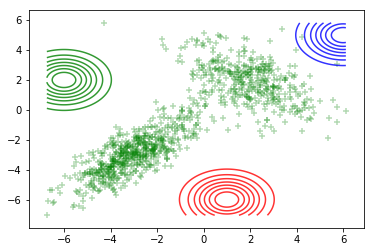

In [18]:
g_mean = [[1,-6],[-6,2],[6,5],[0,0],[4,0],[-6,-6]]
g_sigma = [[[1,0],[0,1]],
        [[1,0],[0,1]],
          [[1,0],[0,1]],
          [[1,0],[0,1]],
          [[1,0],[0,1]],
          [[1,0],[0,1]]]
pi = [1.0/K for i in range(K)]
clus = ['r','g','b','y',"c", "m"]
gauss = make_gauss_model(g_mean,g_sigma)
draw(gauss)

In [19]:
def ganma_cal():
    ganma = []
    for i in range(N):
        sum_p = 0.0
        p=[]
        for j in range(K):
            sum_p += pi[j]*gauss[j].pdf([samples[i][0],samples[i][1]])
        for j in range(K):
            p.append(pi[j]*gauss[j].pdf([samples[i][0],samples[i][1]])/sum_p)
        ganma.append(p)
    return ganma

[0.82796262529620734, 0.17203737470379257, 6.7386581267589634e-31]


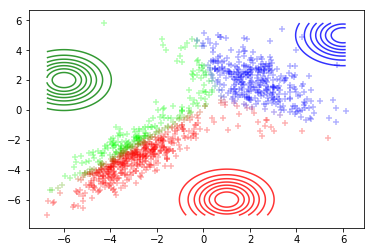

In [20]:
ganma = ganma_cal()
draw2(gauss,ganma)
print(ganma[0])

In [21]:
def cal():
    for k in range(K):
        sum_r = 0.0
        for n in range(N):
             sum_r += ganma[n][k]
        N_k.append(sum_r)
    return N_k

In [22]:
N_k = []
N_k = cal()
print(N_k)

[450.37374047205628, 217.31563246055984, 332.31062706738396]


In [23]:
def cal_3():
    #行列の初期化
    mu = np.zeros((K,D))
    S = np.zeros((K,D,D))
    for k in range(K):
        sum_r = 0.0
        sum_x = 0.0
        sum_y = 0.0
        for n in range(N):
            #sum_x += ganma[n][k]*samples[0][n]
            #sum_y += ganma[n][k]*samples[1][n]
            sum_r += ganma[n][k]*samples[n]
        mu[k] = sum_r/N_k[k]
        sigma = []
        sigma = [np.array([samples[j][0],samples[j][1]])-np.array([mu[k]]) for j in range(N)]
        S[k] = (sum([ganma[j][k]*sigma[j].T.dot(sigma[j])for j in range(N)])/N_k[k])
        
    return mu,S

[[[ 3.09810602  2.05003647]
  [ 2.05003647  1.88107246]]

 [[ 2.88956009  3.26963601]
  [ 3.26963601  5.26429862]]

 [[ 1.51183732 -0.80578761]
  [-0.80578761  1.51309226]]]


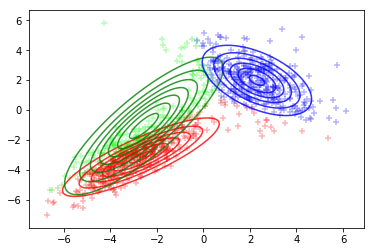

In [27]:
mu,S = cal_3()
gauss = make_gauss_model(mu,S)
draw2(gauss,ganma)
print(S)

In [14]:
def M_step(N,mu,S):
    alpha_0 = 0.001
    beta_0 = 0.001
    nu_0 = 1.0
    m_0 = np.zeros((K,D))
    m = np.zeros((K,D))
    W_0 = np.identity(2)
    alpha=[]
    beta=[]
    nu=[]
    W = np.zeros((K,D,D))
    for k in range(K):
        alpha.append(alpha_0 + N_k[k])
        beta.append(beta_0 + N_k[k])
        nu.append(nu_0 + N_k[k])
        #x = beta_0*m_0 + N[k]*mu[k][0]
        #y = beta_0*m_0 + N[k]*mu[k][1]
        #tmp = beta_0*m_0[k] + N[k]*mu[k]
        #m[k] = tmp/beta[k]
        m[k] = (beta_0*m_0[k] + N_k[k]*mu[k])/beta[k]
    sigma = []
    sigma = [mu[j]-m[j] for j in range(K)]
    for k in range(K):
        tmp = (beta_0*N_k[k]*sigma[k].T.dot(sigma[k]))/(beta_0 + N_k[k])
        tmp2 = la.inv(W_0)+N_k[k]*S[k]+tmp
        W[k] = la.inv(tmp2)
    #S[k] = (sum([ganma[j][k]*sigma[j].T.dot(sigma[j])for j in range(N)])/N_k[k])
    #sigma = []
    #sigma = [np.array([mu[k][0],mu[k][1]])-np.array([m_0,m_0]) for k in range(K)]
    #for k in range(K):
        #x = beta_0*N[k]*sigma[k].T.dot(sigma[k])/(beta_0+N[k])
        #t = la.inv(W_0)+N[k]*S[k]+x
        #W.append(la.inv(t))
    return alpha,beta,nu,m,W

In [15]:
alpha,beta,nu,m,W = M_step(N,mu,S)
print(W)

[[[ 0.00255573 -0.00278201]
  [-0.00278201  0.00420732]]

 [[ 0.00531868 -0.00330053]
  [-0.00330053  0.00292151]]

 [[ 0.00276945  0.00147193]
  [ 0.00147193  0.00276716]]]


In [21]:
def E_step(alpha,beta,nu,m,W):
    E_ln_A = []
    E_ln_pi = []
    E_mu_A = []
    r = []
    for k in range(K):
        tmp = sum([digamma((nu[k]+1-i)/2)for i in range(1,D+1)])
        #print("tmp:{}".format(tmp))
        E = tmp +D*math.log(2)+math.log(la.norm(W[k]))
        #print("E:{}".format(E))
        E_ln_A.append(E)
        
        E = digamma(alpha[k])-digamma(sum(alpha))
        E_ln_pi.append(E)
    #print(E_ln_pi)
    #print(E_ln_pi)
    for n in range(N):
        tmp = [(D/beta[k])+nu[k]*np.dot((samples[n] - m[k]),np.dot(W[k],(samples[n] - m[k]).T)) for k in range(K)]
        E_mu_A.append(tmp)
    #print(tmp)
    for n in range(N):
        tmp = [np.exp(E_ln_pi[k] + E_ln_A[k]/2 - D*math.log(2*math.pi)-E_mu_A[n][k]/2) for k in range(K)]
        tmp2 = tmp/sum(tmp)
        r.append(tmp)
    return E_ln_A,E_ln_pi,r

In [22]:
E_ln_A,E_ln_pi,r = E_step(alpha,beta,nu,m,W)
print(r[0])

[0.24310568831545643, 0.060600433314867662, 3.4460411598699985e-22]


0.001